<a href="https://colab.research.google.com/github/fernandopr11/ModelFaceInceptionV1FineTuning/blob/main/FacialRecognitionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Instalacion de dependencias
!pip install torch torchvision facenet-pytorch opencv-python pillow numpy pandas matplotlib seaborn scikit-learn tqdm albumentations mtcnn coremltools onnx onnx-coreml tqdm albumentations

In [2]:
# PASO 1. Carga del modelo preentrenado

#Importacion de librerias iniciales para la configuracion de directorios y carga del modelo preentrenado
import torch
import torch.nn as nn
from facenet_pytorch import InceptionResnetV1
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive

In [3]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Configuración
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dispositivo: cpu


In [4]:
# Crear directorios en Google Drive
base_path = Path("/content/drive/MyDrive/Reconocimiento_Facial")
models_dir = base_path / "models"
data_dir = base_path / "data"
results_dir = base_path / "results"

# Crear estructura de directorios
base_path.mkdir(exist_ok=True)
models_dir.mkdir(exist_ok=True)
data_dir.mkdir(exist_ok=True)
results_dir.mkdir(exist_ok=True)


In [5]:
# Subdirectorios para organizar mejor los datos
(data_dir / "raw").mkdir(exist_ok=True)
(data_dir / "processed").mkdir(exist_ok=True)
(data_dir / "train_test").mkdir(exist_ok=True)

In [6]:
# Veriricar la creacion de los directorios
print(f"Directorios creados en: {base_path}")
print(f"📁 models: {models_dir}")
print(f"📁 data: {data_dir}")
print(f"📁 results: {results_dir}")

Directorios creados en: /content/drive/MyDrive/Reconocimiento_Facial
📁 models: /content/drive/MyDrive/Reconocimiento_Facial/models
📁 data: /content/drive/MyDrive/Reconocimiento_Facial/data
📁 results: /content/drive/MyDrive/Reconocimiento_Facial/results


In [7]:
print("Cargando InceptionResnetV1...")
model = InceptionResnetV1(
    pretrained='vggface2',  # Pesos preentrenados en VGGFace2
    classify=False,         # Solo extracción de características
    device=device
).eval()

Cargando InceptionResnetV1...


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [8]:
print(f"Modelo cargado exitosamente")
print(f"Parámetros: {sum(p.numel() for p in model.parameters()):,}")

Modelo cargado exitosamente
Parámetros: 27,910,327


In [9]:
# Prueba de funcionamiento
test_input = torch.randn(1, 3, 160, 160).to(device)
with torch.no_grad():
    embedding = model(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Embedding shape: {embedding.shape}")
print(f"Embedding size: {embedding.shape[1]} (512 esperado)")

Input shape: torch.Size([1, 3, 160, 160])
Embedding shape: torch.Size([1, 512])
Embedding size: 512 (512 esperado)


In [10]:
# Guardar el modelo en Google Drive
model_path = models_dir / "inception_resnet_v1_base.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'config': {
        'pretrained': 'vggface2',
        'embedding_size': 512,
        'img_size': 160
    }
}, model_path)

print(f"Modelo guardado en: {model_path}")

Modelo guardado en: /content/drive/MyDrive/Reconocimiento_Facial/models/inception_resnet_v1_base.pth


In [11]:

#PASO 2: Preprocesamiento del dataset y augmentación de datos
import cv2
from PIL import Image, ImageEnhance
from facenet_pytorch import MTCNN
from tqdm import tqdm
import albumentations as A
import random


In [12]:
# PASO 2.1: Configurar detector de rostros MTCNN
print("🔍 Configurando detector de rostros MTCNN...")
mtcnn = MTCNN(
    image_size=160,              # Tamaño de salida del rostro (compatible con InceptionResnetV1)
    margin=20,                   # Margen alrededor del rostro
    min_face_size=80,            # Tamaño mínimo de rostro a detectar
    thresholds=[0.6, 0.7, 0.7],  # Umbrales de detección [P, R, O]
    factor=0.709,                # Factor de escala para pirámide de imágenes
    post_process=True,           # Normalización automática
    device=device
)
print("✅ Detector MTCNN configurado")

🔍 Configurando detector de rostros MTCNN...
✅ Detector MTCNN configurado


In [13]:
# PASO 2.2: Función para detectar y extraer rostros
def detectar_y_extraer_rostro(imagen_path, mostrar=False):
    """
    Detecta y extrae el rostro principal de una imagen usando MTCNN
    """
    try:
        # Cargar imagen
        img = Image.open(imagen_path).convert('RGB')

        # Detectar rostro con MTCNN
        img_cropped = mtcnn(img)

        if img_cropped is not None:
            # Convertir tensor a PIL Image
            if isinstance(img_cropped, torch.Tensor):
                # Desnormalizar de [-1,1] a [0,255]
                img_cropped = (img_cropped + 1) / 2 * 255
                img_cropped = img_cropped.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
                img_cropped = Image.fromarray(img_cropped)

            if mostrar:
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(img)
                plt.title("Original")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(img_cropped)
                plt.title(f"Rostro Detectado ({img_cropped.size})")
                plt.axis('off')
                plt.show()

            return img_cropped
        else:
            print(f"⚠️  No se detectó rostro en {imagen_path.name}")
            return None

    except Exception as e:
        print(f"❌ Error procesando {imagen_path.name}: {str(e)}")
        return None


👤 EXTRAYENDO ROSTROS DE IMÁGENES ORIGINALES...
📂 Buscando en: /content/drive/MyDrive/Reconocimiento_Facial/data/raw/
📸 Encontradas 15 fotos originales

🖼️  Ejemplo de detección con: B51AD7BC-10A4-4CFD-AACB-55AE1850B930.JPG


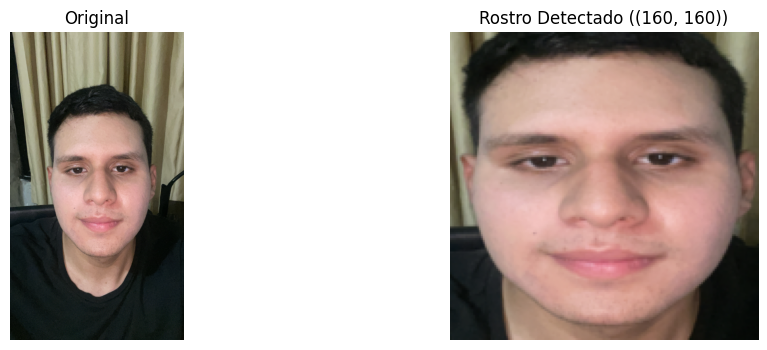


🔄 Procesando 15 imágenes...


Detectando rostros: 100%|██████████| 15/15 [00:04<00:00,  3.11it/s]

✅ Rostros extraídos: 15/15


In [28]:
# PASO 2.3: Extraer rostros de todas las imágenes originales
print("\n👤 EXTRAYENDO ROSTROS DE IMÁGENES ORIGINALES...")

# Buscar todas las fotos en data/raw
fotos_originales = list(data_dir.glob("raw/*.jpg")) + list(data_dir.glob("raw/*.JPG")) + \
                  list(data_dir.glob("raw/*.png")) + list(data_dir.glob("raw/*.PNG"))

print(f"📂 Buscando en: {data_dir}/raw/")
print(f"📸 Encontradas {len(fotos_originales)} fotos originales")

if len(fotos_originales) == 0:
    print("❌ No se encontraron fotos en /data/raw/")
    print("Verifica que las fotos estén en la carpeta correcta")
else:
    rostros_detectados = []
    nombres_rostros = []

    # Mostrar primera imagen como ejemplo
    if len(fotos_originales) > 0:
        print(f"\n🖼️  Ejemplo de detección con: {fotos_originales[0].name}")
        rostro_ejemplo = detectar_y_extraer_rostro(fotos_originales[0], mostrar=True)

    # Procesar todas las imágenes
    print(f"\n🔄 Procesando {len(fotos_originales)} imágenes...")
    for i, foto_path in enumerate(tqdm(fotos_originales, desc="Detectando rostros")):
        rostro = detectar_y_extraer_rostro(foto_path)
        if rostro is not None:
            # Guardar rostro procesado
            nombre_rostro = f"face_{i+1:03d}.jpg"
            ruta_rostro = data_dir / "processed" / nombre_rostro
            rostro.save(ruta_rostro, quality=95)

            rostros_detectados.append(nombre_rostro)

    print(f"✅ Rostros extraídos: {len(rostros_detectados)}/{len(fotos_originales)}")

In [29]:
# PASO 2.4: Configurar augmentación de datos
print("\n🔧 CONFIGURANDO AUGMENTACIÓN DE DATOS...")

# Configurar transformaciones con Albumentations (versión SIMPLE Y QUE FUNCIONA)
transform_augment = A.Compose([
    # Transformaciones básicas
    A.HorizontalFlip(p=0.4),                                                   # Espejo horizontal
    A.Rotate(limit=8, p=0.6),                                                  # Rotación suave ±8°

    # Variaciones de ILUMINACIÓN (probadas y que funcionan)
    A.OneOf([
        # Iluminación normal
        A.RandomBrightnessContrast(
            brightness_limit=0.15, contrast_limit=0.1, p=1.0
        ),
        # Poca iluminación (ambiente oscuro)
        A.RandomBrightnessContrast(
            brightness_limit=(-0.25, 0.0), contrast_limit=0.15, p=1.0
        ),
        # Iluminación alta (muy iluminado)
        A.RandomBrightnessContrast(
            brightness_limit=(0.05, 0.2), contrast_limit=0.1, p=1.0
        ),
    ], p=0.7),

    # Ajustes de color SUTILES (sin problemas)
    A.HueSaturationValue(
        hue_shift_limit=8, sat_shift_limit=12, val_shift_limit=10, p=0.4
    ),

    # Transformaciones geométricas suaves
    A.Affine(
        translate_percent=0.02,     # Desplazamiento mínimo 2%
        scale=(0.98, 1.02),        # Escala muy sutil 98%-102%
        rotate=5,                  # Rotación máxima 5°
        p=0.4
    ),

    # Efectos de cámara simples
    A.OneOf([
        # Ligero desenfoque
        A.GaussianBlur(blur_limit=2, p=1.0),
        # Sin efecto
        A.NoOp(p=1.0),
    ], p=0.2),  # Solo 20% probabilidad

    # Ajuste gamma para diferentes exposiciones
    A.RandomGamma(gamma_limit=(85, 115), p=0.3),

], p=0.85)  # 85% probabilidad de aplicar alguna transformación

def aplicar_augmentacion(imagen_pil, num_variaciones=25):
    """
    Aplica múltiples augmentaciones a una imagen PIL
    """
    variaciones = []

    # Convertir PIL a numpy para Albumentations
    img_np = np.array(imagen_pil)

    for i in range(num_variaciones):
        # Aplicar augmentación
        augmented = transform_augment(image=img_np)
        img_aug = augmented['image']

        # Convertir de vuelta a PIL
        img_pil_aug = Image.fromarray(img_aug)
        variaciones.append(img_pil_aug)

    return variaciones


🔧 CONFIGURANDO AUGMENTACIÓN DE DATOS...


In [35]:

# PASO 2.5: Generar variaciones aumentadas
if len(rostros_detectados) > 0:
    print(f"\n📈 GENERANDO VARIACIONES AUMENTADAS...")

    # Configurar cuántas variaciones por rostro
    VARIACIONES_POR_ROSTRO = 20  # Ajusta este número según necesites
    total_variaciones = len(rostros_detectados) * VARIACIONES_POR_ROSTRO

    print(f"🎯 Generando {VARIACIONES_POR_ROSTRO} variaciones por cada {len(rostros_detectados)} rostros")
    print(f"📊 Total de imágenes finales: {total_variaciones}")

    contador_total = 0

    # Crear carpeta para augmentadas
    augmented_dir = data_dir / "processed" / "augmented"
    augmented_dir.mkdir(exist_ok=True)

    # Procesar cada rostro detectado
    for nombre_rostro in tqdm(rostros_detectados, desc="Generando variaciones"):
        # Cargar rostro original
        ruta_rostro = data_dir / "processed" / nombre_rostro
        rostro_original = Image.open(ruta_rostro)

        # Generar variaciones
        variaciones = aplicar_augmentacion(rostro_original, VARIACIONES_POR_ROSTRO)

        # Guardar cada variación
        base_name = nombre_rostro.replace('.jpg', '')
        for i, variacion in enumerate(variaciones):
            nombre_variacion = f"{base_name}_aug_{i+1:03d}.jpg"
            ruta_variacion = augmented_dir / nombre_variacion
            variacion.save(ruta_variacion, quality=90)
            contador_total += 1

    print(f"✅ Augmentación completada!")
    print(f"📊 Estadísticas finales:")
    print(f"   • Fotos originales: {len(fotos_originales)}")
    print(f"   • Rostros detectados: {len(rostros_detectados)}")
    print(f"   • Variaciones generadas: {contador_total}")
    print(f"   • Total de imágenes procesadas: {len(rostros_detectados) + contador_total}")


📈 GENERANDO VARIACIONES AUMENTADAS...
🎯 Generando 20 variaciones por cada 15 rostros
📊 Total de imágenes finales: 300


Generando variaciones: 100%|██████████| 15/15 [00:03<00:00,  4.54it/s]

✅ Augmentación completada!
📊 Estadísticas finales:
   • Fotos originales: 15
   • Rostros detectados: 15
   • Variaciones generadas: 300
   • Total de imágenes procesadas: 315



📋 VERIFICACIÓN DE RESULTADOS...
📁 Estructura final del dataset:
   📂 /data/raw/: 15 archivos (originales)
   📂 /data/processed/: 15 archivos (rostros detectados)
   📂 /data/processed/augmented/: 300 archivos (variaciones)
   🎯 Dataset total: 315 imágenes

🖼️  MOSTRANDO EJEMPLO DE VARIACIONES:


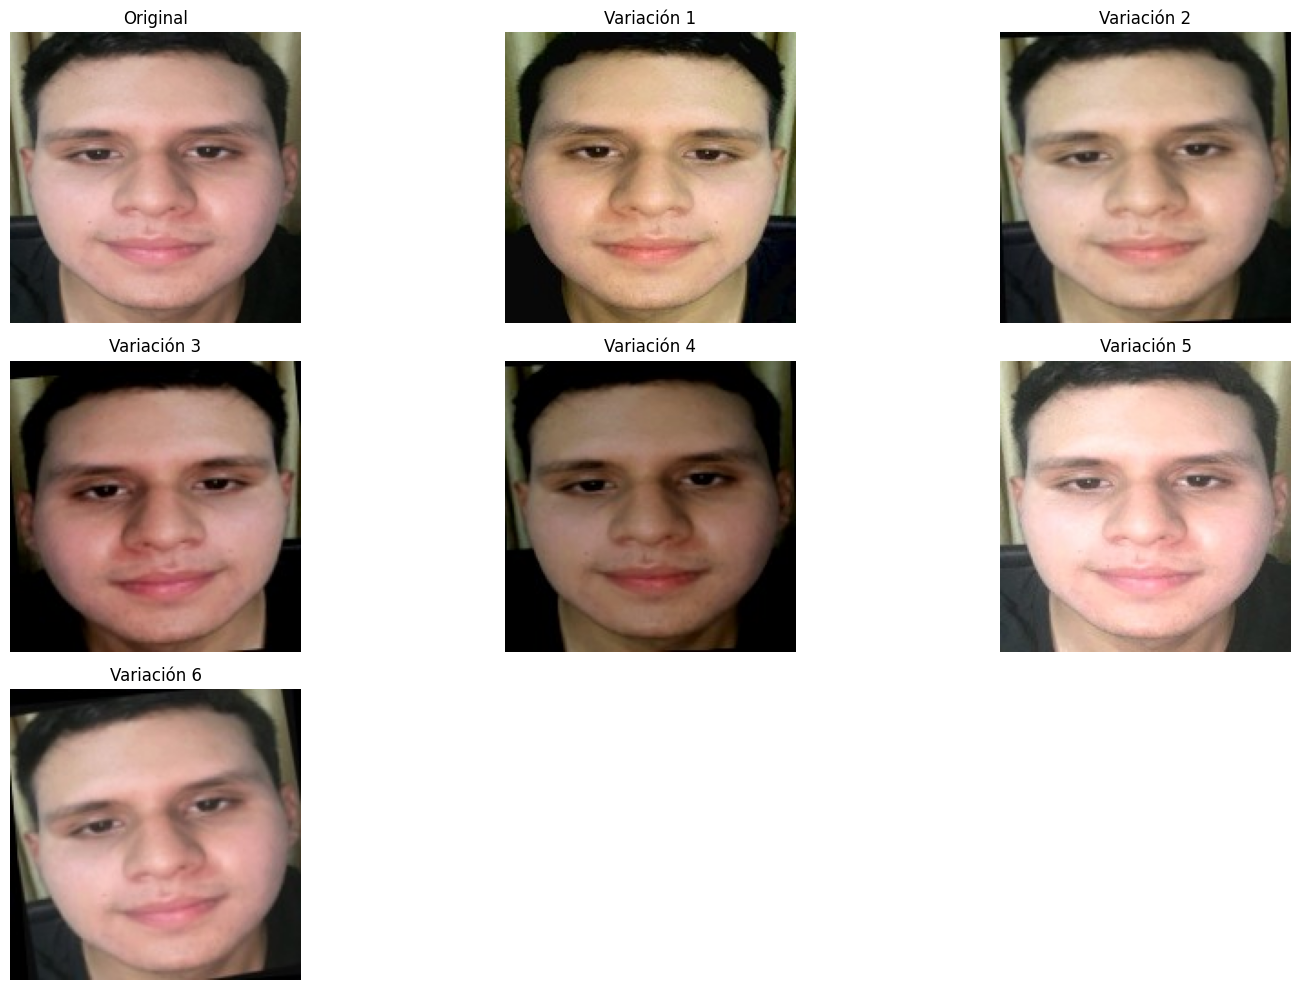

✅ Dataset procesado y listo para entrenamiento


In [37]:
# PASO 2.6: Verificar resultados
print(f"\n📋 VERIFICACIÓN DE RESULTADOS...")

# Contar archivos en cada carpeta
raw_count = len(list((data_dir / "raw").glob("*.*")))
processed_count = len(list((data_dir / "processed").glob("*.jpg")))
augmented_count = len(list((data_dir / "processed" / "augmented").glob("*.jpg")))

print(f"📁 Estructura final del dataset:")
print(f"   📂 /data/raw/: {raw_count} archivos (originales)")
print(f"   📂 /data/processed/: {processed_count} archivos (rostros detectados)")
print(f"   📂 /data/processed/augmented/: {augmented_count} archivos (variaciones)")
print(f"   🎯 Dataset total: {processed_count + augmented_count} imágenes")

# Mostrar algunas variaciones como ejemplo
if augmented_count > 0:
    print(f"\n🖼️  MOSTRANDO EJEMPLO DE VARIACIONES:")

    # Cargar imagen original y algunas variaciones
    rostro_original = Image.open(data_dir / "processed" / rostros_detectados[0])
    variaciones_ejemplo = list((data_dir / "processed" / "augmented").glob("face_001_aug_*.jpg"))[:6]

    plt.figure(figsize=(15, 10))

    # Mostrar original
    plt.subplot(3, 3, 1)
    plt.imshow(rostro_original)
    plt.title("Original")
    plt.axis('off')

    # Mostrar 6 variaciones
    for i, var_path in enumerate(variaciones_ejemplo):
        plt.subplot(3, 3, i+2)
        var_img = Image.open(var_path)
        plt.imshow(var_img)
        plt.title(f"Variación {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
print(f"✅ Dataset procesado y listo para entrenamiento")